# Infer ***soma*** -  2️⃣ 

> WARNING: (🚨🚨🚨🚨 Steps 3-9 depend on establishing a good solution here.)
>> #### Because we do NOT have a direct cell membrane / soma signal, this segmentation is trickiest and potentially most problematic part of the overall sub-cellular component inference pipeline. We are using the nuclei of the cell with the brightest total fluorescence (all channels) to identify a single soma for all downstream steps. The Soma (via the Cytosol mask) will be used to define ALL subsequent sub-cellular Objects.

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #2: ***soma***/cell body in order to understand interactome 

Infer a segmentation of the cell body -- the ***soma*** -- in order to measure its shape, position, and size.

CONTEXT: "Soma" is used here becuase subsequent experiments will contain neurons who's soma has a similar shape to an iPS cell body.

This method is used in the case where there is no cell fill/membrane marker.

We will infer the soma from a combination of fluorescent signals. The current selection includes the lysosomes, ER, and Golgi (e.g., 'Ch = 1, 3, 5) which have some intracellular fluorescence - likely from off target marker localization to the entire soma and/or the cell membrane. There are two other channels, the residual channel from linear unmixing (e.g. `ch = 7`) and the lipid droplet channel (e.g., `ch = 6`) that could more lead to more unbiased selection of the entire soma. However, the drawback of these two markers is that they are present in every cell which makes downstream cell selection more challenging. To expand on this, we will be collecting per cell measurements, so each cell area has to be segmented individually even if there are two appropriately labeled cells within one field of view. 

In the long term we can build of a database of "ground truth" by sourcing additional markers which can be iteratively improved.  For example using the Allen Cell "Label Free" segmentation results should provide a good corroboration or constraints to the procedures outlined below.  

A first possible _workflow_ is illustrated below.

### IMAGE PROCESSING  OBJECTIVE :  infer ***soma***
 
> #### Note:  we are using the Nuclei of the brightest cell to aid in inferring the Soma and Cytosol objects.   Because we do NOT have a direct cell membrane / soma signal this is the trickiest and potentially problematic part of the overall sub-cellular component inference.   The Soma (via the Cytosol mask) will be used to define ALL subsequent sub-cellular Objects.

## preamble

1. imports
2. setup
3. ~~choose_Z~~
4. infer-soma
    * input
    * pre-processing
    * core processing
    * post-processing
    * select individual cell
    * output
5. export soma





## IMPORTS

In [2]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Union, Tuple, List

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_holes   # function for post-processing (size filter)

from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                     read_ome_image,
                                                                     import_inferred_organelle,
                                                                     export_inferred_organelle,
                                                                    list_image_files)

                                             
from infer_subc_2d.utils.img import *

from infer_subc_2d.organelles import  fixed_infer_nuclei

%load_ext autoreload
%autoreload 2



## SETUP

CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.


In [4]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )                       

In [5]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"
im_type = ".czi"



In [6]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


##  infer ***soma***

>WORKFLOW #1  - modified MCZ 3/20

Segmentation on a 3 channel composite as per 3/20 pipeline from MCZ
Summary - Starting with a linear combination of three signals,  the signal is smoothed and non-linearly combined (logrithmic and edge detected) for thresholding. 
## summary of steps

➡️ INPUT
- multi-channel sum (6.*1, 3, 2.*5)
- nuclei mask

PRE-PROCESSING
- rescaling
- denoise/smoothing
- log transform inensities
- scale to max 1.0
- create non-linear aggregate of log-intensity + scharr edge filtered intensity

CORE PROCESSING
- mask object segmentation at bottom

POST-PROCESSING
  - fill holes
  - remove small objects

OUTPUT ➡️ 
- mask of SOMA


> #### Note: this pipeline will eventually include a selection step to identify the soma that are properly labeled with all fluorescent markers. This could be one single cell per image, or more if applicable data is available.


## INPUT prototype

Combine multiple channels that will allow inference of the soma.

Note: the selected channels were chosen based on their qualitative ability to fill the cytoplasmic area of the cell. 



## GET inferred nuclei

In [7]:

# nuclei_fname = "/Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"
nuclei = import_inferred_organelle("nuclei", meta_dict, out_data_path)

if nuclei is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    out_file_n = export_inferred_organelle(nuclei, "nuclei", meta_dict, out_data_path)
    print(f"calculated nuclei. wrote {out_file_n}")
else:
    print(f"loaded nuclei from {out_data_path}")


loaded nuclei from /Users/ahenrie/Projects/Imaging/data/out


In [8]:
# get_interior_labels.   Removes any segmentations on the edges, but we probably don't want to use it
nuclei_labls = get_interior_labels(nuclei)


In [9]:

###################
# INPUT
###################
struct_img_raw = (6. * img_data[LYSO_CH].copy().astype(np.double) +
                  1. * img_data[ER_CH].copy().astype(np.double) + 
                  2. * img_data[GOLGI_CH].copy().astype(np.double))


In [10]:
# confirm our functions work as expected:

weights =  (0,6,0,2, 0,1) # _,lyso,_, golgi,_,1,0,0,_,_
struct_img_raw2 = weighted_aggregate(img_data, *weights)
# use splat so we can also break out the arguments for our napari widget later
struct_img_raw3 = weighted_aggregate(img_data, 0,6,0,2, 0,1)

struct_img_raw[0,0:10,0], struct_img_raw2[0,0:10,0], struct_img_raw3[0,0:10,0]


(array([34548., 31003., 27969., 57573., 66992., 67514., 63489., 75837.,
        95956., 84172.]),
 array([34548., 31003., 27969., 57573., 66992., 67514., 63489., 75837.,
        95956., 84172.]),
 array([34548., 31003., 27969., 57573., 66992., 67514., 63489., 75837.,
        95956., 84172.]))

## PRE-PROCESSING prototype


In [11]:
from infer_subc_2d.organelles.soma import raw_soma_MCZ, non_linear_soma_transform_MCZ, choose_max_label_soma_union_nucleus

struct_img_raw = raw_soma_MCZ(img_data)
###################
# PRE_PROCESSING
###################
#
# DEFAULT PARAMETERS:

med_filter_size = 15  
gaussian_smoothing_sigma = 1.34


structure_img_smooth =  scale_and_smooth(struct_img_raw,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)


# # NON-Linear aggregation
# log_image, d = log_transform( structure_img_smooth ) 
# log_image = intensity_normalization(  log_image,  scaling_param=[0] )
# edges = filters.scharr(log_image)
# composite_soma = intensity_normalization(  edges,  scaling_param=[0] ) + log_image 

composite_soma = non_linear_soma_transform_MCZ(structure_img_smooth)


## CORE PROCESSING

In [12]:
###################
# CORE_PROCESSING
###################
low_level_min_size =  150

################# part 1
bw = masked_object_thresh(composite_soma, 
                                                th_method='ave', 
                                                cutoff_size=low_level_min_size, 
                                                th_adjust= 0.5)



## POST-PROCESSING

In [13]:
###################
# POST_PROCESSING
###################
hole_width = 50
#removed_holes = remove_small_holes(bw, hole_width ** 2 )
removed_holes = hole_filling_linear_size(bw, 
                                                    hole_min=0, 
                                                    hole_max=hole_width)


small_object_width = 45

cleaned_img = size_filter_linear_size(removed_holes, 
                                                                min_size = small_object_width)

cleaned_img2 = fill_and_filter_linear_size(bw, hole_min=0, hole_max=hole_width, min_size= small_object_width)

In [14]:
# make sure it works..
np.all(cleaned_img==cleaned_img2)

True

## POST POST-PROCESSING

In [15]:
###################
# POST- POST_PROCESSING
###################

# # below can be performed by: masked_inverted_watershed(img_in,markers, mask)
# inverted_img = 1. - composite_soma
# labels_out = watershed(
#             inverted_img,
#             markers=label(nuclei),
#             connectivity=np.ones((1, 3,3), bool),
#             mask=watershed_mask,
#             )
nuc_labels = label(nuclei)
soma_labels = masked_inverted_watershed(structure_img_smooth,nuc_labels, cleaned_img)

keep_label = get_max_label(composite_soma, soma_labels)

soma_out = np.zeros_like(soma_labels)
soma_out[soma_labels == keep_label] = 1
soma_out[nuc_labels == keep_label] = 1

soma_out2 = choose_max_label_soma_union_nucleus(structure_img_smooth, cleaned_img, nuclei) 


## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [16]:

viewer = napari.view_image(
        cleaned_img,
    )


In [17]:

viewer.scale_bar.visible = True

viewer.add_labels(
    soma_out,
)



<Labels layer 'soma_out' at 0x103f9acd0>

## SAVE inferred nuclei to .tif file

Based on the _prototyping_ above define the function to infer nuclei.  


In [18]:

out_file_n = export_inferred_organelle(soma_out, "soma", meta_dict, out_data_path)


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


saved file: /Users/ahenrie/Projects/Imaging/data/out/soma_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff


## DEFINE parameterized  `_infer_soma` function

A function to infer_soma from our (Channel, 1 Z slice, X, Y) image accourding the the following parameters: 
-  

In [19]:
from infer_subc_2d.organelles.soma import raw_soma_MCZ, non_linear_soma_transform_MCZ

##########################
# 1. infer_soma
##########################

def _infer_soma_MCZ(in_img: np.ndarray,
                nuclei_obj: np.ndarray,
    median_sz: int,
    gauss_sig: float,
    mo_method: str,
    mo_adjust: float,
    mo_cutoff_size: int,
    max_hole_w: int,
    small_obj_w: int
) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_obj: 
        a 3d image containing the inferred nuclei
    median_sz: 
        width of median filter for _soma_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _soma_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for soma signal post-processing
    small_obj_w: 
        minimu object size cutoff for soma signal post-processing

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of soma

    """
    nuc_ch = NUC_CH
    ###################
    # EXTRACT
    ###################
    struct_img = raw_soma_MCZ(in_img)
    scaled_signal = struct_img.copy() # already scaled

    ###################
    # PRE_PROCESSING
    ###################                         
    ################# part 1- soma

    # Linear-ish processing
    struct_img = median_filter_slice_by_slice(struct_img, size=median_sz)

    struct_img = image_smoothing_gaussian_slice_by_slice( struct_img,
                                                                                sigma=gauss_sig)

    struct_img_non_lin = non_linear_soma_transform_MCZ(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                                th_method=mo_method, 
                                                cutoff_size=mo_cutoff_size, 
                                                th_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    # struct_obj = hole_filling_linear_size(struct_obj, 
    #                                             hole_min =0 , 
    #                                             hole_max=max_hole_w) 
    # struct_obj = size_filter_linear_size(struct_obj, 
    #                                                 min_size= small_obj_w)
    struct_obj = fill_and_filter_linear_size(struct_obj, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)

    ###################
    # POST- POST_PROCESSING
    ###################
    soma_out = choose_max_label_soma_union_nucleus(struct_img, struct_obj, nuclei_obj) 

    return soma_out





## DEFINE `_fixed_infer_soma` function

Based on the _prototyping_ above define the function to infer soma. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [20]:
##########################
# 1. fixed_infer_soma
##########################


def _fixed_infer_soma_MCZ(in_img: np.ndarray, nuclei_obj: np.ndarray) -> np.ndarray:
    """
    Procedure to infer soma from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_obj: 
        a 3d image containing the inferred nuclei

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of soma
    """
    

    ###################
    # PARAMETERS
    ###################   
    median_sz = 15
    gauss_sig = 1.34
    mo_method = "ave"
    mo_adjust = 0.5
    mo_cutoff_size = 150
    max_hole_w = 50
    small_obj_w = 45

    soma_out = _infer_soma(in_img,
                                                nuclei_obj,
                                                median_sz,
                                                gauss_sig,
                                                mo_method,
                                                mo_adjust,
                                                mo_cutoff_size,
                                                max_hole_w,
                                                small_obj_w) 

    return soma_out




In [21]:
from infer_subc_2d.organelles.soma import fixed_infer_soma_MCZ

soma_object =  fixed_infer_soma_MCZ(img_data, nuclei) 


## Visualize  2


In [22]:
viewer.add_image(
    soma_object,
    scale=scale,
    opacity=0.3,
)    


viewer.add_labels(
    label(nuclei),
    scale=scale,
    opacity=0.3,
)


<Labels layer 'Labels' at 0x166f4ba30>

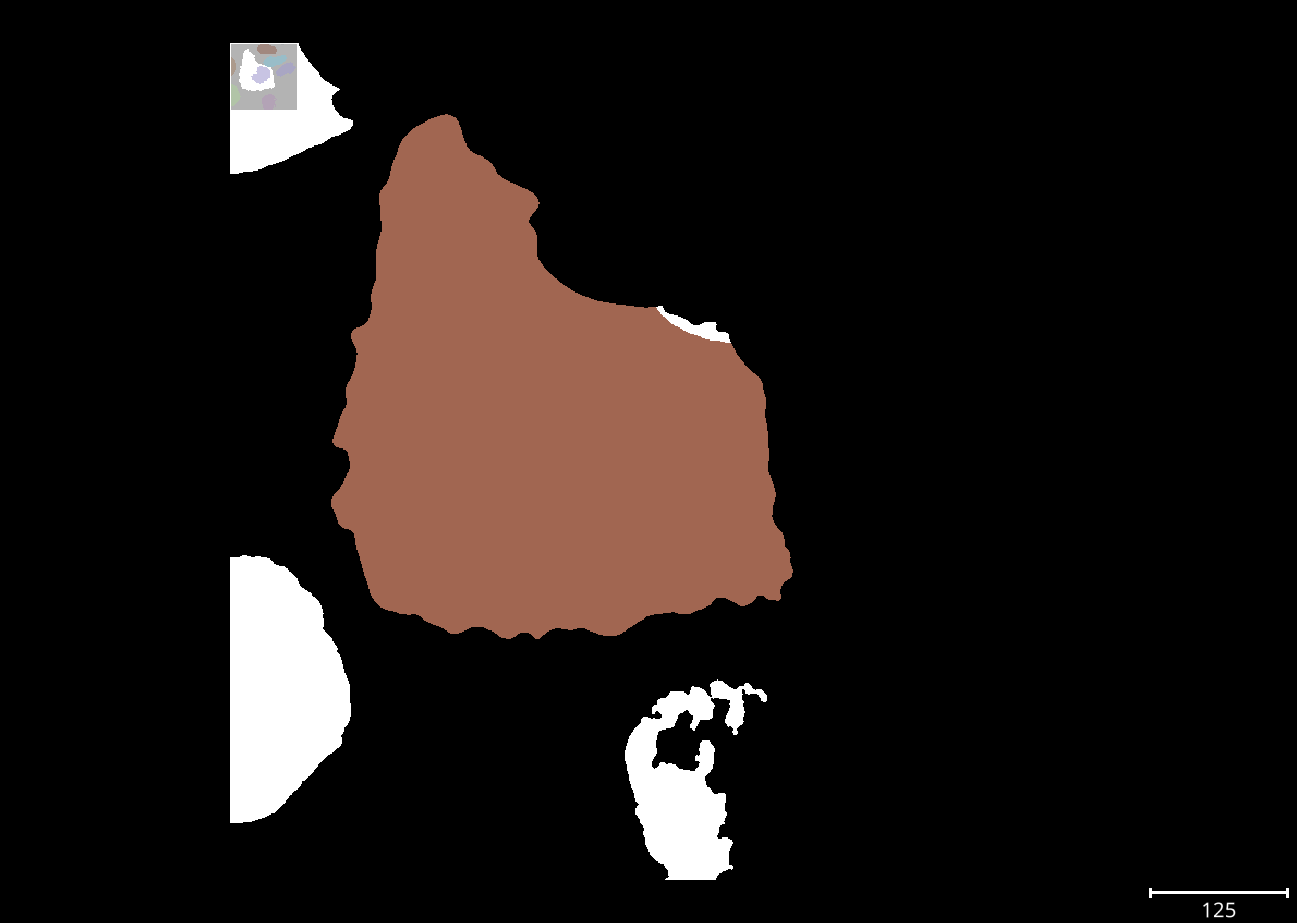

In [23]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [24]:
viewer.close()

In [ ]:

def _masked_object_thresh(
    structure_img_smooth: np.ndarray, th_method: str, cutoff_size: int, th_adjust: float
) -> np.ndarray:
    """
    wrapper for applying Masked Object Thresholding with just two parameters via `MO` from `aicssegmentation`
    Parameters
    ------------
    structure_img_smooth: np.ndarray
        a 3d image
    th_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cutoff_size: 
        Masked Object threshold `size_min`
    th_adjust: 
        Masked Object threshold `local_adjust`

    Returns
    -------------
        np.ndarray segmentation 

    """

    struct_obj = MO(
        structure_img_smooth,
        global_thresh_method=th_method,
        object_minArea=cutoff_size,
        extra_criteria=True,
        local_adjust=th_adjust,
        return_object=False,
        dilate=True,
    )
    return struct_obj


In [ ]:
def get_max_label(raw_signal: np.ndarray, labels_in: np.ndarray) -> np.ndarray:
    """keep only the label with the maximum raw signal
        Parameters
    ------------
    raw_signal:
        the image to filter on
    labels_in:
        labels to consider

    Returns
    -------------
        np.ndarray of labels corresponding to the largest total signal

    """
    all_labels = np.unique(labels_in)[1:]

    total_signal = [raw_signal[labels_in == label].sum() for label in all_labels]
    # combine NU and "labels" to make a SOMA
    keep_label = all_labels[np.argmax(total_signal)]

    return keep_label

def choose_max_label_soma_union_nucleus(soma_img: np.ndarray, soma_obj: np.ndarray, nuclei_obj: np.ndarray) -> np.ndarray:
    """find the label with the maximum soma from watershed on the nuclei + plus the corresponding nuclei labels

        Parameters
    ------------
    soma_img:
        the soma image intensities
    soma_obj:
        thresholded soma mask
    nuclei_obj:
        inferred nuclei

    Returns
    -------------
        np.ndarray of soma+nuc labels corresponding to the largest total soma signal 

    """
    nuc_labels = label(nuclei_obj)
    soma_labels = masked_inverted_watershed(soma_img,nuc_labels, soma_obj)

    keep_label = get_max_label(soma_img, soma_labels)

    soma_out = np.zeros_like(soma_labels)
    soma_out[soma_labels == keep_label] = 1
    soma_out[nuc_labels == keep_label] = 1

    return soma_out


In [ ]:

def raw_soma_MCZ(img_in: np.ndarray, scale_min_max:bool = True) -> np.ndarray:
    """define soma image
    SOMA_W = (6.,1.,2.)
    SOMA_CH = (LYSO_CH,ER_CH,GOLGI_CH)

    Parameters
    ------------
    img_in
        a 3d image
    scale_min_max: 
        scale to [0,1] if True. default True

    Returns
    -------------
        np.ndarray scaled aggregate

    """
    weights = (0, 6, 0, 2, 0, 1)
    if scale: 
        return min_max_intensity_normalization(weighted_aggregate(img_in, *weights))
    else: 
        return weighted_aggregate(img_in, *weights)

---------------------
# TEST `_infer_soma`  function defined above


##


In [25]:

SO_label =  _fixed_infer_soma(img_2D) 

In [23]:
from infer_subc_2d.organelles import fixed_infer_soma

soma_ =  fixed_infer_soma(img_data, nuclei) 

In [24]:

viewer.add_image(
    soma_,
    scale=scale 
)

<Image layer 'soma_' at 0x1658ac4c0>

Write the `infer_soma` spec to the widget json

In [28]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_soma =  {
        "name": " infer soma mask (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_soma",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_soma", _fixed_infer_soma, overwrite=True)

function fixed_infer_soma is already in all_functions.json
overwriting  fixed_infer_soma


1

In [29]:

_infer_soma =  {
        "name": " infer soma mask",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_soma",
        "parameters": {
                "median_sz_soma": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig_soma": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "median_sz_nuc": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig_nuc": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "mo_method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                                "triangle",
                                "median",
                                "ave_tri_med"
                                ]
                },
                "mo_adjust": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "mo_cutoff_size": {
                        "data_type": "int",
                        "increment": 10,
                        "max": 250,
                        "min": 10,
                        "widget_type": "slider"
                },
                "thresh_factor": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.2,
                        "min": 0.6,
                        "widget_type": "slider"
                },
                "thresh_min": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": .9,
                        "min": 0.0,
                        "widget_type": "slider"
                },
                "thresh_max": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 1.0,
                        "min": 0.1,
                        "widget_type": "slider"
                },
                "max_hole_w_nuc": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 40,
                        "min": 4,
                        "widget_type": "slider"
                },           
                "small_obj_w_nuc": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                },                           
                "max_hole_w_soma": {
                        "data_type": "int",
                        "increment": 2,
                        "max": 100,
                        "min": 20,
                        "widget_type": "slider"
                },           
                "small_obj_w_soma": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                },        
        }
}

add_function_spec_to_widget_json("infer_soma", _infer_soma, overwrite=True )



function infer_soma is already in all_functions.json
overwriting  infer_soma


1

In [30]:

_raw_soma_MCZ =  {
        "name": "define weighted aggregate soma signal (MCZ-cellprofiler)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "raw_soma_MCZ",
        "parameters": None
        }

add_function_spec_to_widget_json("raw_soma_MCZ", _raw_soma_MCZ, overwrite=True)

function raw_soma_MCZ is already in all_functions.json
overwriting  raw_soma_MCZ


1

In [31]:

_non_linear_soma_transform_MCZ =  {
        "name": "non-linear filter of soma signal (MCZ-cellprofiler)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "non_linear_soma_transform_MCZ",
        "parameters": None
        }

add_function_spec_to_widget_json("non_linear_soma_transform_MCZ", _non_linear_soma_transform_MCZ)

function non_linear_soma_transform_MCZ is already in all_functions.json


0

In [32]:

_masked_inverted_watershed =  {
        "name": "watershed on inverted image and masked",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "masked_inverted_watershed",
        "parameters": None
        }

add_function_spec_to_widget_json("masked_inverted_watershed", _masked_inverted_watershed)

function masked_inverted_watershed is already in all_functions.json


0

In [33]:

_choose_max_label =  {
        "name": "keep only the label with the maximum raw signa",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "choose_max_label",
        "parameters": None
        }

add_function_spec_to_widget_json("choose_max_label", _choose_max_label)

function choose_max_label is already in all_functions.json


0

In [34]:

_min_max_intensity_normalization =  {
        "name": "Min Max Intesity Normalization",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "min_max_intensity_normalization",
        "parameters": None
        }

add_function_spec_to_widget_json("min_max_intensity_normalization", _min_max_intensity_normalization)

function min_max_intensity_normalization is already in all_functions.json


0

In [35]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_masked_object_thresh =  {
        "name": "Masked Object Threshold wrapper for widgets",
        "python::module": "infer_subc_2d.utils.img",
        "python::function": "masked_object_thresh",
        "parameters": {
                "th_method": {
                        "data_type": "str",
                        "widget_type": "drop-down",
                        "options": [
                        "triangle",
                        "median",
                        "ave_tri_med"
                        ]
                },
                "cutoff_size": {
                        "data_type": "int",
                        "widget_type": "slider",
                        "min": 0,
                        "max": 2000,
                        "increment": 50
                },
                "th_adjust": {
                        "data_type": "float",
                        "widget_type": "slider",
                        "min": 0,
                        "max": 2,
                        "increment": 0.02
                }
        }
}

add_function_spec_to_widget_json("masked_object_thresh", _masked_object_thresh, overwrite=True)

function masked_object_thresh is already in all_functions.json
overwriting  masked_object_thresh


1

--------------------------

# TEST `infer_soma` exported functions


In [43]:
from infer_subc_2d.organelles import fixed_infer_soma

soma_mask =  fixed_infer_soma(img_2D) 

## Visualize  2


In [37]:
# viewer = napari.Viewer()

viewer.scale_bar.visible = True

viewer.add_labels(
    soma_mask,
    scale=scale,
    blending='additive'
)


<Labels layer 'soma_mask' at 0x1819c34f0>

In [38]:

from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)
viewer.close()

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [39]:
def make_infer_soma_step_by_step_dict():
    """
    crete .json version of infer_soma
    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
    notes = []

    ###################
    # EXTRACT
    ###################   
    # struct_img = _raw_soma_MCZ(in_img)
    step_name.append("1")
    function_name.append("raw_soma_MCZ")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)
    notes.append(f" this creates an aggregate signal for the soma" )

    step_name.append("2")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = NUC_CH) )
    parent.append(0)

    ###################
    # PRE_PROCESSING
    ###################
    #SOMA
    step_name.append("3")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(1)


    step_name.append("4")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 15 ))
    parent.append(3)


    step_name.append("5")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(4)

    step_name.append("6")
    function_name.append("non_linear_soma_transform_MCZ")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    #NUC
    step_name.append("7")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(2)

    step_name.append("8")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(7)

    step_name.append("9")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(8)

    ###################
    # CORE_PROCESSING
    ###################
    # SOMA
    step_name.append("10")
    function_name.append("masked_object_thresh")
    category.append("core")
    parameter_values.append(dict( th_method="ave_tri_med",
                                                            cutoff_size = 100,
                                                            th_adjust = 0.5))
    parent.append(6)


    # NUCLEI
    step_name.append("11")
    function_name.append("apply_log_li_threshold")
    category.append("core")
    parameter_values.append(dict(thresh_factor = 0.9, 
                                                            thresh_min = .1,
                                                            thresh_max = 1.))
    parent.append(9)


    ###################
    # POST_PROCESSING
    ###################
    # NUCLEI
    step_name.append("12")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=5**2, fill_2d=True))
    parent.append(11)

    step_name.append("13")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(12)

    step_name.append("14")
    function_name.append("label")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append(13)

    # SOMA
    step_name.append("15")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=25**2, fill_2d=True))
    parent.append(10)

    step_name.append("16")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(15)

    step_name.append("17")
    function_name.append("masked_inverted_watershed")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([ 5 , 14, 16])

    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    step_name.append("18")
    function_name.append("choose_max_label")
    category.append("postpostprocessing")
    parameter_values.append(None)
    parent.append([5, 17])

    ##########################
    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [40]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_soma_stepbystep_dict = make_infer_soma_step_by_step_dict()

write_workflow_json("conf_2.1.soma_stepbystep", infer_soma_stepbystep_dict )

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_2.1.soma_stepbystep.json')

In [41]:
def make_infer_soma_step_by_step_from_raw_dict():
    """
    Procedure to infer nuclei from linearly unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    soma_mask: np.ndarray
        mask

    Returns
    -------------
    nuclei_object
        mask defined extent of NU

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []

    ###################
    # EXTRACT
    ###################   
    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    # SOMA
    step_name.append("2")
    function_name.append("raw_soma_MCZ")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(1)

    # NUC
    step_name.append("3")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = NUC_CH) )
    parent.append(1)

    ###################
    # PRE_PROCESSING
    ###################
    # SOMA
    step_name.append("4")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(2)

    step_name.append("5")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 15 ))
    parent.append(4)

    step_name.append("6")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(5)

    step_name.append("7")
    function_name.append("non_linear_soma_transform_MCZ")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(6)

    #NUC
    step_name.append("8")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(3)

    step_name.append("9")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(8)

    step_name.append("10")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.4 ))
    parent.append(9)

    ###################
    # CORE_PROCESSING
    ###################
    # SOMA
    step_name.append("11")
    function_name.append("masked_object_thresh")
    category.append("core")
    parameter_values.append(dict( th_method="ave_tri_med",
                                                            cutoff_size = 100,
                                                            th_adjust = 0.5))
    parent.append(7)

    # NUC
    step_name.append("12")
    function_name.append("apply_log_li_threshold")
    category.append("core")
    parameter_values.append(dict(thresh_factor = 0.9, 
                                                            thresh_min = .1,
                                                            thresh_max = 1.))
    parent.append(10)

    ###################
    # POST_PROCESSING
    ###################
    # nUC
    step_name.append("13")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=5**2, fill_2d=True))
    parent.append(12)

    step_name.append("14")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(13)

    step_name.append("15")
    function_name.append("label")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append(14)


    # SOMA
    step_name.append("16")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=25**2, fill_2d=True))
    parent.append(11)

    step_name.append("17")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 15**2  ))
    parent.append(16)

    step_name.append("18")
    function_name.append("masked_inverted_watershed")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([  7 , 15,17 ])

    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    step_name.append("19")
    function_name.append("choose_max_label")
    category.append("postpostprocessing")
    parameter_values.append(None)
    parent.append([6,18])

    ##########################
    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [42]:

infer_soma_stepbystep_from_raw_dict = make_infer_soma_step_by_step_from_raw_dict()

write_workflow_json("conf_1.1.soma_stepbystep_from_raw", infer_soma_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.1.soma_stepbystep_from_raw.json')

-------------
## SUMMARY

The above explains the overall framework.  

### NEXT: INFER NUCLEI

proceed to [02_infer_nuclei.ipynb](./02_infer_nuclei.ipynb)
